# CS445 Final Project - Seathru

In [70]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [71]:
import collections
import numpy as np
import scipy.optimize as optimize
import math
from PIL import Image
from matplotlib import pyplot as plt
from skimage.restoration import denoise_bilateral
from skimage.morphology import closing, disk, square

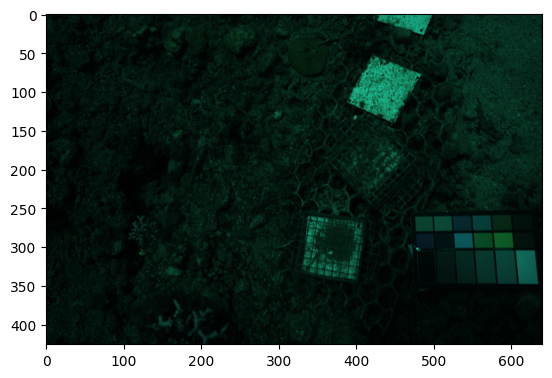

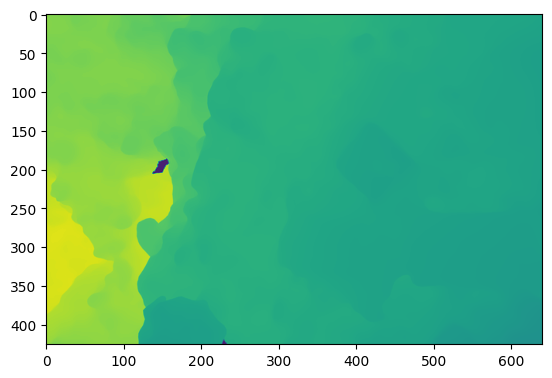

In [72]:
# Read Image and Depth file

img = Image.open("samples/img.png")
raw_depth = Image.open("samples/depth.tif")

size = 640

# Cap dimension to size while maintaining ratio
img.thumbnail((size, size), Image.Resampling.LANCZOS)
raw_depth.thumbnail((size, size), Image.Resampling.LANCZOS)

img = np.float32(img) / 255.0
raw_depth = np.array(raw_depth).astype(np.float32)

plt.imshow(img)
plt.show()

plt.imshow(raw_depth)
plt.show()

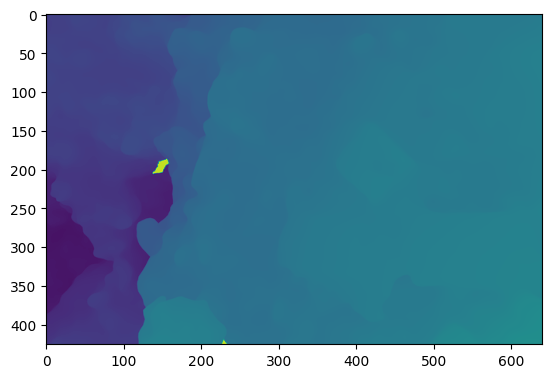

In [73]:
# Preprocess depth

# Normalize to 0-1 and scale based on inverse
depths = (raw_depth - np.min(raw_depth)) / (np.max(raw_depth) - np.min(raw_depth))
depths = (2 * (1.0 - depths)) + 2

plt.imshow(depths)
plt.show()

In [74]:
# Partition depth map into 10 bins and search for pixel value (r,g,b) in the bottom 1 percentile
def sample_backscatter_points(img, depths, depth_cutoff):
	# Divide depth over 10 bins (as in paper)
	depth_bins = np.histogram_bin_edges(depths, bins=10, range=(np.min(depths), np.max(depths)))
	mean_intensity = np.mean(img, axis=2)

	estimation_points = []

	for i in range(10):
		# Find idx of points with depth in bin and greater than min depth
		idx_in_bin = np.where((depths >= depth_bins[i]) & (depths <= depth_bins[i+1]) & (depths > (np.min(depths) + depth_cutoff)))
		sorted_idx = np.argsort(mean_intensity[idx_in_bin])
		
		# Use bottom 1 percentile of triples (as in paper)
		num_points = math.ceil(0.01 * len(mean_intensity))
		
		for idx in sorted_idx[:num_points]:
			depth = depths[idx_in_bin][idx]
			pixel = img[idx_in_bin][idx]
			estimation_points.append([depth, pixel[0], pixel[1], pixel[2]]) 

	return np.array(estimation_points)

In [75]:
# [depth, r, g, b]
depth_cutoff = 0
estimation_points = sample_backscatter_points(img, depths, depth_cutoff)

In [76]:
# Backscatter estimation from paper
def backscatter_model(depth, B_inf, beta_b, J, beta_d):
    return B_inf * (1 - np.exp(-beta_b * depth)) + J * np.exp(-beta_d * depth)

# Estimating B_inf, beta_b, J, beta_d subject to the bounds of [0,1],[0,5],[0,1], and [0,5]
def optimize_parameters(val, depth):
    parameters, _ = optimize.curve_fit(
        f=backscatter_model,
        xdata=depth,
        ydata=val,
        bounds=(np.array([0, 0, 0, 0]), np.array([1, 5, 1, 5]))
    )
    return parameters

# Estimate backscatter parameters for each channel
def estimate_backscatter(esimation_points):
    estimated_values = []
    parameters = []

    for channel in range(3):
        value, depth = esimation_points[:, channel+1], esimation_points[:, 0]
        
        parameter = optimize_parameters(value, depth)

        estimated_values.append(backscatter_model(depths, *parameter))
        parameters.append(parameter)

    return np.stack(estimated_values, axis=2), parameters

In [77]:
# [r_BackScatter, g_BackScatter, b_BackScatter], [r_params, g_params, b_params]
backscatter, parameters = estimate_backscatter(estimation_points)

print(backscatter.shape)

(426, 640, 3)


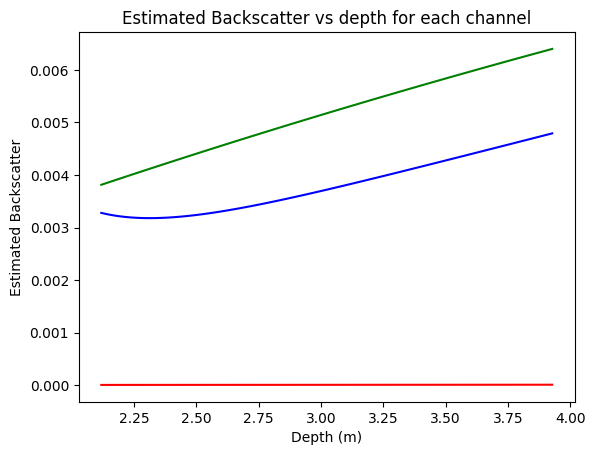

In [78]:
# Estimated Backscatter vs depth for each channel
for idx, color in enumerate(['r', 'g', 'b']):
    x = np.linspace(np.min(estimation_points[:, 0]), np.max(estimation_points[:, 0]), 100)
    y = backscatter_model(x, *parameters[idx])
    plt.plot(x.ravel(), y.ravel(), c=color)

plt.xlabel('Depth (m)')
plt.ylabel('Estimated Backscatter')
plt.title('Estimated Backscatter vs depth for each channel')
plt.show()

In [79]:
def create_depth_groups(depth_data, epsilon, min_group_size):
	epsilon = (np.max(depth_data) - np.min(depth_data)) * epsilon
	depth_groups = np.zeros(depth_data.shape, dtype=np.int32)
	groups_counter = {}

	# Label depths data into groups based on epsilon for similarity
	remaining_points = np.argwhere(depth_groups == 0)
	id = 1
	while remaining_points.size > 0:
		start = remaining_points[np.random.choice(remaining_points.shape[0])]
		queue = collections.deque([start])
		
		while queue:
			curr = queue.pop()
			if np.abs(depth_data[curr[0], curr[1]] - depth_data[start[0], start[1]]) <= epsilon:
				depth_groups[curr[0], curr[1]] = id
				groups_counter[id] = groups_counter[id] + 1 if id in groups_counter else 1

				for x, y in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
					new_x, new_y = curr[0] + x, curr[1] + y
					if 0 <= new_x < depth_data.shape[0] and 0 <= new_y < depth_data.shape[1]:
						if depth_groups[new_x, new_y] == 0:
							queue.append([new_x, new_y])
		id += 1
		remaining_points = np.argwhere(depth_groups == 0)

	# Merge small groups with larger groups
	for label, size in groups_counter.items():
		if size < min_group_size:
			for x, y in zip(*np.where(depth_groups == label)):
				depth_groups[x, y] = bfs(depth_groups, x, y)

	# Use morphological smoothing (based on open source code)
	smoothed_groups = closing(depth_groups, square(3))

	return smoothed_groups

# BFS to search for a point's nearest neighbor thats not in its group
def bfs(depth_groups, x, y):
	original_label = depth_groups[x,y]
	checked = np.zeros_like(depth_groups, dtype=bool)
	queue = collections.deque([(x, y)])

	while queue:
		curr = queue.pop()
		if depth_groups[curr[0], curr[1]] != original_label:
			return depth_groups[curr[0], curr[1]]
		
		checked[curr[0], curr[1]] = True
		for x, y in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
			new_x, new_y = curr[0] + x, curr[1] + y
			if 0 <= new_x < depth_groups.shape[0] and 0 <= new_y < depth_groups.shape[1]:
				queue.append([new_x, new_y])
	return 0

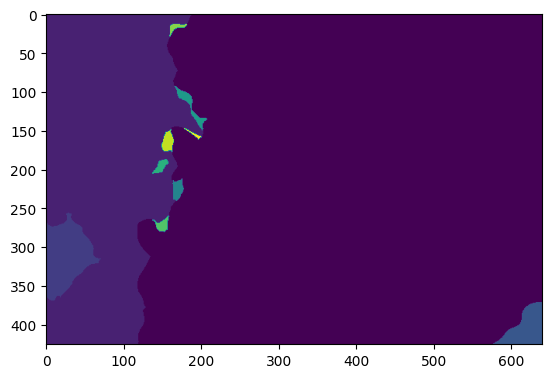

In [80]:
# Contruct a depth group map based on LSAC from paper
epsilon = 0.1
min_group_size = 50

depth_groups = create_depth_groups(depths, epsilon, min_group_size)
num_groups = len(np.unique(depth_groups))

plt.imshow(depth_groups)
plt.show()


In [81]:
# Utilize local space aver-age color (LSAC) described in paper
# Constants are provided from public code as it is not given in paper.
def illumination_map(img, backscatter, depth_groups, num_groups):
	brightness = 3
	locality = 0.5
	iterations = 100
	tol = 1E-5

	direct_sig = img - backscatter  # Paper: I = D + B
	lsac = np.zeros_like(img) # local space average color

	# Update average local contrasts
	for _ in range(iterations):
		updated_lsac = np.zeros_like(img)
		for j in range(num_groups):
			pixels = np.where(depth_groups == (j + 1))
			sum_cs = np.sum(lsac[pixels], axis=0)
			updated_lsac[pixels] = (1 / (np.size(pixels[0]) - 1)) * (sum_cs - lsac[pixels])
		
		next_lsac = (direct_sig * locality) + (updated_lsac * (1 - locality))
		abs_diff = np.abs(lsac - next_lsac)
		
		if np.max(abs_diff) < tol:
			break
		
		lsac = next_lsac

	result = brightness * denoise_bilateral(np.maximum(0, lsac), channel_axis=-1)
	return result

In [82]:
ill_map = illumination_map(img, backscatter, depth_groups, num_groups)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


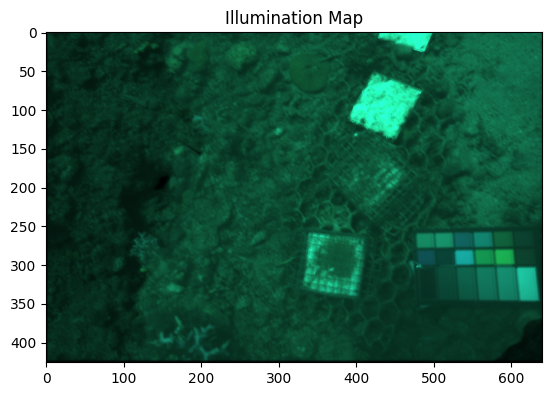

In [83]:
plt.imshow(ill_map)
plt.title('Illumination Map')
plt.show()

In [84]:
# Paper: Dependency of wideband attenuation on depth
def wideband_attenuation_model(depths, a, b, c, d):
    return a * np.exp(b * depths) + c * np.exp(d * depths)

# Estimation of wideband attuenuation using known depth map
# Constants are provided from public code as it is not given in paper.
def estimate_attentuation(depths, illumination):
	eps = 1E-8
	min_depth_fraction = 0.01
	r = 6

	estimated_attuenation = []
	refined_attentuations = []
	coefs = []
	min_depth = np.min(depths) + (min_depth_fraction * (np.max(depths) - np.min(depths)))

	for c in range(3):
		# Paper: Given estimate of the illuminant map,  we can make a coarse esimation on wideband attentuation
		ill = illumination[:,:,c]
		coarse_attentuation = -np.log(ill + eps) / (depths + eps) # coarse estimation
		attentuation = denoise_bilateral(closing(np.maximum(0, coarse_attentuation), disk(r))) # denoise
		estimated_attuenation.append(attentuation)

		# Paper: Estimate coefficients that models wideband attentuation's dependency on depth
		pixels = np.where(np.logical_and(ill > 0, np.logical_and(depths > min_depth, attentuation > eps)))	
		parameters, _ = optimize.curve_fit(
			f=wideband_attenuation_model,
			xdata=depths[pixels],
			ydata=attentuation[pixels],
			p0=np.abs(np.random.random(4)) * np.array([1.0, -1.0, 1.0, -1.0]),
			# Paper: Subject to bounds of [0,−∞,0,−∞], [∞,0,∞,0]
			bounds=(np.array([0, -np.inf, 0, -np.inf]), np.array([np.inf, 0, np.inf, 0]))
		)

		refined_attenuation = wideband_attenuation_model(depths, *parameters)
		refined_attentuations.append(refined_attenuation)
		coefs.append(parameters)

	return np.stack(estimated_attuenation, axis=2), np.stack(refined_attentuations, axis=2), coefs

In [85]:
estimated_attuenation, refined_attentuation, coefs = estimate_attentuation(depths, ill_map)

Attentuation coefficients: a, b, c, d
[ 7.32525837e+01 -1.91252808e+00  7.87292259e-01 -7.81777393e-14]
[ 2.10582708e-01 -2.10022708e-12  4.03333634e+01 -1.80129712e+00]
[ 2.78054833e-01 -1.84316079e-14  3.31105389e+01 -1.64275328e+00]


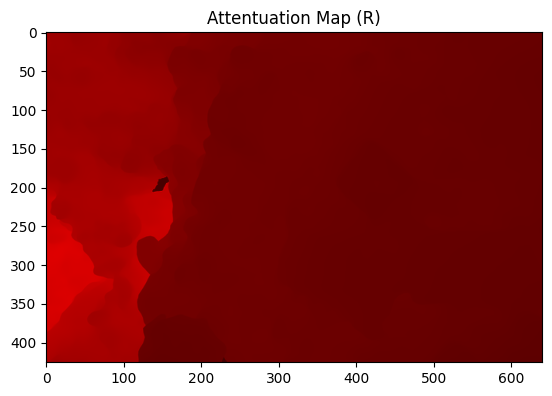

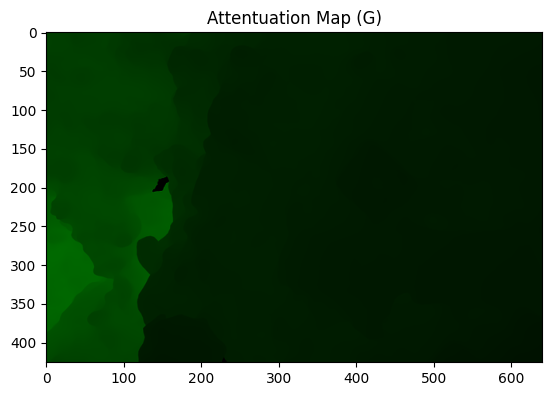

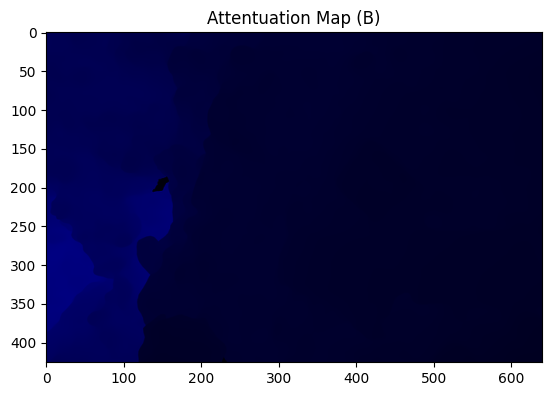

In [86]:
print("Attentuation coefficients: a, b, c, d")
for i in range(len(coefs)):
	print(coefs[i])

# Plot Attentuation map per channel
channels = ['R', 'G', 'B']
for c in range(3):
	refined_attentuation_copy = np.copy(refined_attentuation)
	refined_attentuation_copy = (refined_attentuation_copy - np.min(refined_attentuation_copy)) / (np.max(refined_attentuation_copy) - np.min(refined_attentuation_copy))
	
	# Set channels of what we are not plotting to 0
	for i in range(3):
		if i != c:
			refined_attentuation_copy[:, :, i] = 0

	plt.imshow(refined_attentuation_copy)
	plt.title('Attentuation Map (' + channels[c] + ')')
	plt.show()

C:\Users\jjang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


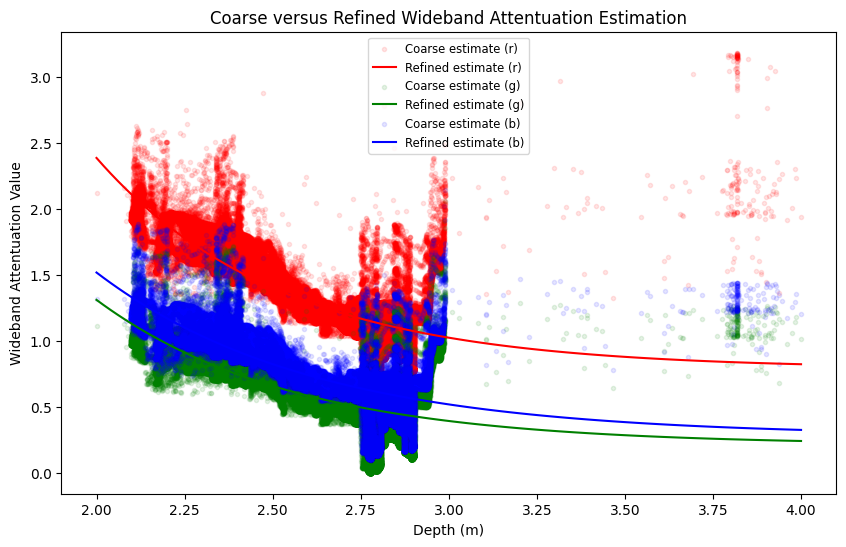

In [87]:
# Plot coarse versus refined wideband attentuation
channels = ['r', 'g', 'b']
x = np.linspace(np.min(depths), np.max(depths), 100)

plt.figure(figsize=(10, 6))

for channel in range(3):
    # Coarse
	attentuation = estimated_attuenation[:,:,channel]
	plt.scatter(depths.ravel(), attentuation.ravel(), c = channels[channel], alpha=0.1, marker='.', 
			 label=f'Coarse estimate ({channels[channel]})')

	# Refined
	y = wideband_attenuation_model(x, *coefs[channel])
	plt.plot(x.ravel(), y.ravel(), c = channels[channel], label=f'Refined estimate ({channels[channel]})')

plt.xlabel('Depth (m)')
plt.ylabel('Wideband Attentuation Value')
plt.title('Coarse versus Refined Wideband Attentuation Estimation')
plt.legend(fontsize='small')
plt.show()

In [107]:
# Paper: Adopt Gray world hypothesis and white balance
def reconstruct_image(img, depths, backscatter, attentuation):
    result = (img - backscatter) * np.exp(attentuation * np.expand_dims(depths, axis=2))
    result = np.clip(result, 0.0, 1.0)

    # white balance based on average of channels
    red, green, blue = 1.0 / np.mean(result, axis=(0, 1))

    avg = (red + green + blue) / 3.0
    result[:, :, 0] *= red / avg
    result[:, :, 1] *= green / avg
    result[:, :, 2] *= blue / avg

    scaled = (result - np.min(result)) / (np.max(result) - np.min(result))
    return scaled

Text(0.5, 1.0, 'Recovered Image')

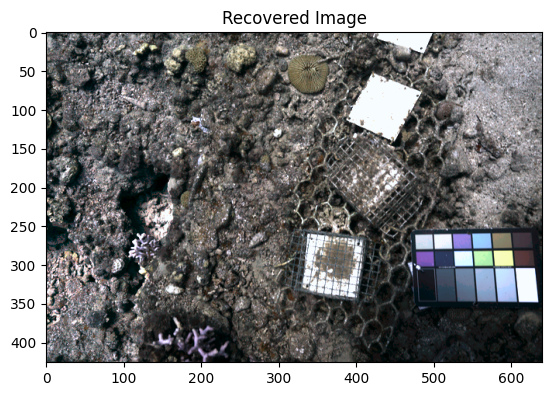

In [108]:
reconstructed_image = reconstruct_image(img, depths, backscatter, refined_attentuation)

plt.imshow(reconstructed_image)
plt.title('Recovered Image')